# Homework for Week 6

Based on GLM (Chapter 10) and counting models (e.g., binomial in Chapter 11).


## Setup



In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.special import expit as logistic

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)  #suppress Arviz warnings

from causalgraphicalmodels import CausalGraphicalModel
import daft

In [2]:
d = pd.read_csv("Data/NWOGrants.csv",
               sep=";")
d.head()

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18


### Create index variables

In [3]:
d["discipline"] = d["discipline"].astype("category")
d["gender"] = d["gender"].astype("category")

In [4]:
d["disc_idx"] = d["discipline"].cat.codes
d["gender_idx"] = d["gender"].cat.codes

Create number of values for each index variable

In [5]:
n_disc = len(d["discipline"].cat.categories)
n_gender = len(d["gender"].cat.categories)
n_disc, n_gender

(9, 2)

List all disciplines:

In [6]:
dict(enumerate(d["discipline"].cat.categories))

{0: 'Chemical sciences',
 1: 'Earth/life sciences',
 2: 'Humanities',
 3: 'Interdisciplinary',
 4: 'Medical sciences',
 5: 'Physical sciences',
 6: 'Physics',
 7: 'Social sciences',
 8: 'Technical sciences'}

### Trim data frame


In [7]:
d.head()

,discipline,gender,applications,awards,disc_idx,gender_idx
0,Chemical sciences,m,83,22,0,1
1,Chemical sciences,f,39,10,0,0
2,Physical sciences,m,135,26,5,1
3,Physical sciences,f,39,9,5,0
4,Physics,m,67,18,6,1


In [8]:
d2 = d.drop(columns=["discipline", "gender"])

In [9]:
d2.head()

,applications,awards,disc_idx,gender_idx
0,83,22,0,1
1,39,10,0,0
2,135,26,5,1
3,39,9,5,0
4,67,18,6,1


# Question 1

>What are the total and indirect causal
effects of gender on grant awards? Consider a mediation path (a pipe) through
discipline. Draw the corresponding DAG and then use one or more binomial
GLMs to answer the question.
What is your causal interpretation? If NWO’s goal is to equalize rates of funding
between the genders, what type of intervention would be most effective?

### Draw DAG

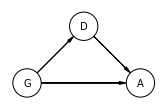

In [10]:
q1dag = CausalGraphicalModel(
    nodes=["G", "D", "A"], edges=[("G", "A"), ("G", "D"), ("D", "A")]
)
pgm = daft.PGM()
coordinates = {"G": (0, 0), "D": (1, 1), "A": (2, 0)}
for node in q1dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in q1dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render();
#plt.gca().invert_yaxis()

### Aggregated binomial model

Start with a simple model that looks at gender.

In [11]:
with pm.Model() as q1m1:
    a = pm.Normal("a", 0, 1.5, shape=n_gender)
    p = pm.Deterministic("p", pm.math.invlogit(a[d2["gender_idx"]]))
    awards = pm.Binomial("awards", p=p, n=d["applications"], observed=d2["awards"])
    trace_q1m1 = pm.sample()   
    sum_q1m1 = az.summary(trace_q1m1, var_names=["a"], round_to=2)
sum_q1m1

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '19724' (I am process '19264')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 2000/2000 [00:03<00:00, 533.38draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.74,0.08,-1.90,-1.60,0.0,0.0,871.40,871.40,861.88,562.3,1.0
a[1],-1.53,0.06,-1.66,-1.42,0.0,0.0,1058.39,1054.76,1060.21,853.2,1.0


The purpose of `var_names=["a"]` is to suppress the values of $p$.  Since it is deterministic, it shows up in the trace. And we get one $p$ for each row of data.

### Calculate differences between index values

Trace contains 1000 samples for parameters `a` and `p`.  For `a`, `a[0]` is female and `a[1]` is male. So the difference of index 0 - 1 is negative when female have a lower log-odds probability of an award.

In [12]:
trace_q1m1["a"].shape

(1000, 2)

Get differences. Note: `from scipy.special import expit as logistic`
Convert to probabilities before subtracting and (of course) before summarizing (mean, etc.).

In [13]:
diff_a = trace_q1m1["a"][:, 0] - trace_q1m1["a"][:, 1]
diff_p = logistic(trace_q1m1["a"][:, 0]) - logistic(trace_q1m1["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
diff_a,-0.20,0.10,-0.41,-0.03
diff_p,-0.03,0.01,-0.05,-0.00


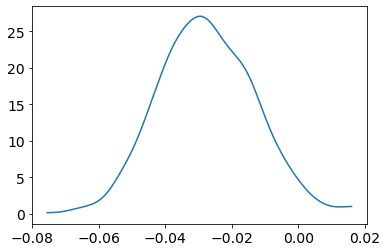

In [14]:
az.plot_dist(diff_p);

### Full model with Discipline pipe

In [15]:
with pm.Model() as q1m2:
    ag = pm.Normal("ag", 0, 1.5, shape=n_gender)
    ad = pm.Normal("ad", 0, 1.5, shape=n_disc)
    p = pm.Deterministic("p", pm.math.invlogit(ag[d2["gender_idx"]] + ad[d2["disc_idx"]]))
    awards = pm.Binomial("awards", p=p, n=d["applications"], observed=d2["awards"])
    trace_q1m2 = pm.sample()
    sum_q1m2 = pm.summary(trace_q1m2, var_names=["ag", "ad"], round_to=2)
sum_q1m2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ad, ag]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 2000/2000 [00:06<00:00, 286.50draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ag[0],-1.34,0.47,-2.26,-0.47,0.06,0.04,58.25,56.94,59.20,96.13,1.04
ag[1],-1.20,0.47,-2.07,-0.31,0.06,0.04,56.43,56.43,57.02,87.72,1.03
ad[0],0.19,0.50,-0.67,1.18,0.06,0.04,65.48,65.48,64.90,117.81,1.03
ad[1],-0.14,0.49,-1.08,0.76,0.06,0.05,56.04,56.04,55.92,71.58,1.03
ad[2],-0.37,0.48,-1.27,0.53,0.06,0.04,65.73,65.73,64.74,78.29,1.03
ad[3],-0.42,0.51,-1.44,0.49,0.06,0.04,68.23,68.23,67.35,78.33,1.03
ad[4],-0.48,0.48,-1.36,0.45,0.06,0.04,58.78,58.78,59.32,64.90,1.03
ad[5],-0.15,0.49,-1.06,0.81,0.06,0.04,62.98,62.98,61.87,97.80,1.03
ad[6],0.16,0.55,-0.89,1.18,0.06,0.04,75.78,75.78,76.60,143.66,1.03
ad[7],-0.60,0.47,-1.49,0.27,0.06,0.04,59.36,59.36,59.16,100.24,1.03


In [16]:
diff_a = trace_q1m2["ag"][:, 0] - trace_q1m2["ag"][:, 1]
diff_p = logistic(trace_q1m2["ag"][:, 0]) - logistic(trace_q1m2["ag"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
diff_a,-0.14,0.11,-0.32,0.07
diff_p,-0.02,0.02,-0.06,0.01


### Interpretation

The effect of gender on award probability becomes negligible conditional on discipline.

## Question 2

>Suppose that the NWO Grants sample has an unobserved confound that influences
both choice of discipline and the probability of an award. One example of
such a confound could be the career stage of each applicant. Suppose that in some
disciplines, junior scholars apply for most of the grants. In other disciplines, scholars
from all career stages compete. As a result, career stage influences discipline as
well as the probability of being awarded a grant.
Add these influences to your DAG from Problem 1. What happens now when you
condition on discipline? Does it provide an un-confounded estimate of the direct
path from gender to an award? Why or why not? Justify your answer with the
back-door criterion. Hint: This is structurally a lot like the grandparents-parentschildren-
neighborhoods example from a previous week.


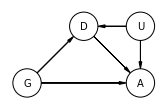

In [17]:
q2dag = CausalGraphicalModel(
    nodes=["G", "D", "A", "U"], edges=[("G", "A"), ("G", "D"), ("D", "A"), ("U", "D"), ("U", "A")]
)
pgm = daft.PGM()
coordinates = {"G": (0, 0), "D": (1, 1), "A": (2, 0), "U": (2, 1)}
for node in q2dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in q2dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render();
#plt.gca().invert_yaxis()

### Response

Conditioning on D opens a back door through `U` (the common cause fork)

## Question 3

>While one eagle feeds, sometimes another will swoop in and try to steal the salmon
from it. Call the feeding eagle the “victim” and the thief the “pirate.” Use the available
data to build one or more binomial GLMs of successful pirating attempts, using
size and age as predictors. Consider any relevant interactions.
1

### Get eagle data
The eagles data frame has 8 rows and 5 columns.

y
Number of successful attempts.

n
Total number of attempts.

P
Size of pirating eagle (L = large, S = small).

A
Age of pirating eagle (I = immature, A = adult).

V
Size of victim eagle (L = large, S = small).

In [18]:
eag = pd.read_csv("Data/eagles.csv",
               sep=",")
eag.head()

,Unnamed: 0,y,n,P,A,V
0,1,17,24,L,A,L
1,2,29,29,L,A,S
2,3,17,27,L,I,L
3,4,20,20,L,I,S
4,5,1,12,S,A,L


### Create index variables

In [19]:
eag["P"] = eag["P"].astype("category")
eag["A"] = eag["A"].astype("category")
eag["V"] = eag["V"].astype("category")

eag["P_idx"] = eag["P"].cat.codes
eag["A_idx"] = eag["A"].cat.codes
eag["V_idx"] = eag["V"].cat.codes
n_P = len(eag["P"].cat.categories)
n_A = len(eag["A"].cat.categories)
n_V = len(eag["V"].cat.categories)
n_P, n_A, n_V

(2, 2, 2)

### Reminder of mapping from indexes to values

In [20]:
dict(enumerate(eag["P"].cat.categories))

{0: 'L', 1: 'S'}

In [21]:
dict(enumerate(eag["A"].cat.categories))

{0: 'A', 1: 'I'}

In [22]:
dict(enumerate(eag["V"].cat.categories))

{0: 'L', 1: 'S'}

In [23]:
eag.drop(columns=["Unnamed: 0", "P", "A", "V"], inplace=True)

### Create model

In [27]:
with pm.Model() as q3m1:
    a_A = pm.Normal("a_A", 0, 1.5, shape=n_A)
    a_P = pm.Normal("a_P", 0, 1.5, shape=n_P)
    a_V = pm.Normal("a_V", 0, 1.5, shape=n_V)
    a_PV = pm.Normal("a_PV", 0, 1.5, shape=(n_P, n_V))
    p = pm.Deterministic("p", pm.math.invlogit(a_P[eag["P_idx"]] + a_A[eag["A_idx"]] + a_V[eag["V_idx"]] + a_PV[eag["P_idx"], eag["V_idx"]]))
    success = pm.Binomial("success", p=p, n=eag["n"], observed=eag["y"])
    trace_q3m1 = pm.sample()   
    sum_q3m1 = az.summary(trace_q3m1, var_names=["a_P", "a_A", "a_V", "a_PV"], round_to=2)
sum_q3m1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_PV, a_V, a_P, a_A]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 2000/2000 [00:10<00:00, 194.11draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_P[0],1.62,1.17,-0.47,3.96,0.04,0.03,932.98,766.54,938.15,660.90,1.00
a_P[1],-1.07,1.16,-3.31,0.99,0.04,0.03,996.34,702.97,997.91,619.19,1.01
a_A[0],0.78,0.96,-0.91,2.74,0.03,0.03,802.15,674.08,797.77,705.47,1.00
a_A[1],-0.27,0.96,-2.08,1.54,0.03,0.03,845.82,519.88,846.83,580.13,1.00
a_V[0],-1.24,1.15,-3.47,0.93,0.04,0.03,894.34,625.19,905.61,665.96,1.00
a_V[1],1.67,1.13,-0.62,3.64,0.04,0.03,974.42,925.44,960.00,647.06,1.00
"a_PV[0,0]",0.14,1.14,-2.01,2.27,0.04,0.03,855.27,571.44,851.90,636.09,1.00
"a_PV[0,1]",1.46,1.29,-0.84,3.86,0.04,0.03,1131.43,888.64,1136.54,871.60,1.00
"a_PV[1,0]",-1.35,1.20,-3.65,0.75,0.04,0.03,1154.87,775.58,1170.65,740.36,1.00
"a_PV[1,1]",0.32,1.19,-1.76,2.65,0.04,0.03,891.82,594.71,875.63,755.91,1.00


### Calculate some contrasts

Pirate size:

In [ ]:
diff_a = trace_q3m1["a_P"][:, 0] - trace_q3m1["a_P"][:, 1]
diff_p = logistic(trace_q3m1["a_P"][:, 0]) - logistic(trace_q3m1["a_P"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

Pirate age:

In [ ]:
diff_a = trace_q3m1["a_A"][:, 0] - trace_q3m1["a_A"][:, 1]
diff_p = logistic(trace_q3m1["a_A"][:, 0]) - logistic(trace_q3m1["a_A"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

Victim size:

In [ ]:
diff_a = trace_q3m1["a_V"][:, 0] - trace_q3m1["a_V"][:, 1]
diff_p = logistic(trace_q3m1["a_V"][:, 0]) - logistic(trace_q3m1["a_V"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

Interaction of pirate size and victim size (large pirate versus large/small victim):

In [ ]:
diff_a = trace_q3m1["a_PV"][:, 0, 0] - trace_q3m1["a_PV"][:, 0, 1]
diff_p = logistic(trace_q3m1["a_PV"][:, 0, 0] - trace_q3m1["a_PV"][:, 0, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, kind="stats", round_to=2)

### Interpretations

1. large pirates are more successful
1. older pirates more successful
1. large victims are less likely to be poached successfully
1. interactions are hard to interpret but work the way you might think they would